<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2022/blob/main/notebooks/es2/AML_2022_HandsOn_2_DnCNN_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Machine Learning for Physics 2021-2022
## Hands-on session 2

Implementation in pytorch of a denoising CNN based on 1D convolutions and [residual learning](https://arxiv.org/abs/1512.03385), trained for the task of isolating the signal from spourious backgrounds in spectra from non-linear fast raman spectroscopy 

Based on a modified version of the DnCNN architecture ([K.Shang et al.](https://arxiv.org/abs/1608.03981)), modified for the new task and to work with one dimensional distributions

*Stefano Giagu - v1.0 - 18.2.2022*

*Stefano Giagu & Andrea - v1.1 - 08.3.2022* - A small addition to Residual learning and on how the number of  parameters is computed

In [1]:
%pip install sklearn
%pip install torchvision
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# needed libaries: numpy, matpoltlib, sklearn, torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torchsummary import summary

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

import os.path


1.10.2+cu102
0.11.3+cu102


In [3]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

# of GPUs available:  1
First GPU type:  Tesla T4
Computation device: cuda



# Load dataset
- it will take a bit of time so please download it before the hands on session

In [4]:
my_file = "FSRamanSpectra_simulationFumero.zip"
if  os.path.exists(my_file):
    print("fle already donwloaded")

fle already donwloaded


In [5]:
# download datasets
if not os.path.exists(my_file):
    !wget http://giagu.web.cern.ch/giagu/CERN/FSRamanSpectra_simulationFumero.zip

In [6]:
if not os.path.exists("FSRamanSpectra_simulationFumero/"):
    !unzip FSRamanSpectra_simulationFumero.zip
else:
    print("Folder already exists")
# the zip file contains several examples of clean (ground truth) and  measured spectra 
# (LowNoise, MixedNoise, August17_MixedNoise (a different model of noise with larger statistics), HighNoise). 

# data is availabel as numpy tensors with shape:
# (5000,801): 5000 examples each one with 801 sampling of the fast raman distribution: LowNoise, MixedNoise, HighNoise
# (15000,801): 15000 examples for August17_MixedNoise

Folder already exists


spectrum shape:  (5000, 801)


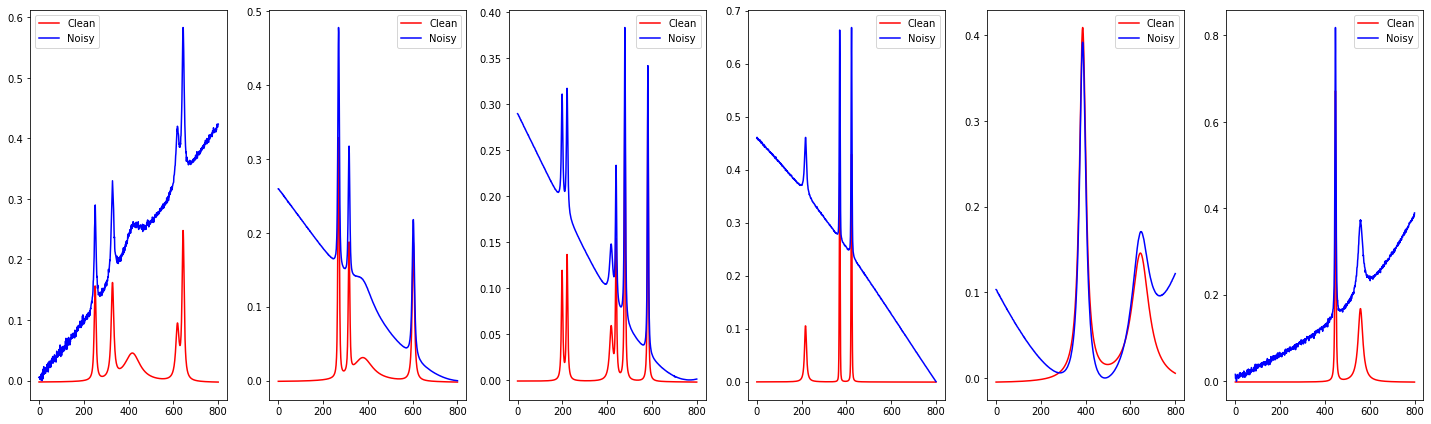

In [22]:
#read one of the datasets
# Let's use the low noise case
true = np.loadtxt('FSRamanSpectra_simulationFumero/Sclean_LowNoise.txt')
meas = np.loadtxt('FSRamanSpectra_simulationFumero/Snoise_LowNoise.txt')

true = true.transpose()
meas = meas.transpose()

print('spectrum shape: ', true.shape)

# normalize all measured spectra amplitudes so that minimum is zero 
for i in range(meas.shape[0]):
    max = meas[i].max()
    min = meas[i].min()
    if (max-min)>0:  
        meas[i] = (meas[i] - min)

#plot few examples
plt.figure(figsize=(20,6))

for idx in range(6):
    plt.subplot(1,6,idx+1)
    plt.plot(true[idx], '-r',label="Clean (ground truth)")
    plt.plot(meas[idx], '-b',label="Noisy (input)")
    plt.legend()

plt.tight_layout()
plt.draw()

# Split the data in Train / Validation / Test

# Add a channel dimention to the data 
 Conv1D operarion accetps a input shape of [batch, channels, (dimention to apply convoluntion, wavenumber in this case)] 
 We will first add it as last dim and then permute the order.

In [8]:
# training, validation, test split

testset_frac = 0.2 # test set fraction wrt whole samples
valiset_frac = 0.25 # validation set fraction wrt training+validation

X_train,X_test,Y_train,Y_test = train_test_split(meas,true,test_size=testset_frac, shuffle=True, random_state=1234)
X_train,X_vali,Y_train,Y_vali = train_test_split(X_train,Y_train,test_size=valiset_frac, shuffle=True, random_state=1234)

X_train = np.expand_dims(X_train, -1)
Y_train = np.expand_dims(Y_train, -1)
X_vali = np.expand_dims(X_vali, -1)
Y_vali = np.expand_dims(Y_vali, -1)
X_test = np.expand_dims(X_test, -1)
Y_test = np.expand_dims(Y_test, -1)

print('X_train shape: ',X_train.shape)
print('Y_train shape: ',Y_train.shape)
print('X_vali shape: ',X_vali.shape)
print('Y_vali shape: ',Y_vali.shape)
print('X_test shape: ',X_test.shape)
print('Y_test shape: ',Y_test.shape)

X_train shape:  (3000, 801, 1)
Y_train shape:  (3000, 801, 1)
X_vali shape:  (1000, 801, 1)
Y_vali shape:  (1000, 801, 1)
X_test shape:  (1000, 801, 1)
Y_test shape:  (1000, 801, 1)


In [9]:
# transform numpy vectors to pytorch tensors

X_train_pt = torch.Tensor(X_train)
Y_train_pt = torch.Tensor(Y_train)
X_vali_pt = torch.Tensor(X_vali)
Y_vali_pt = torch.Tensor(Y_vali)
X_test_pt = torch.Tensor(X_test)
Y_test_pt = torch.Tensor(Y_test)

# switch channel dimension position as needed by pytorch (NOTE: in numpy/keras (dim1,dim2,..., channels) in pytorch (channel, dim1, dim2, ...))

X_train_pt = X_train_pt.permute(0,2,1)
Y_train_pt = Y_train_pt.permute(0,2,1)
X_vali_pt = X_vali_pt.permute(0,2,1)
Y_vali_pt = Y_vali_pt.permute(0,2,1)
X_test_pt = X_test_pt.permute(0,2,1)
Y_test_pt = Y_test_pt.permute(0,2,1)

print(X_train_pt.shape)
print(Y_train_pt.shape)
print(X_vali_pt.shape)
print(Y_vali_pt.shape)
print(X_test_pt.shape)
print(Y_test_pt.shape)

torch.Size([3000, 1, 801])
torch.Size([3000, 1, 801])
torch.Size([1000, 1, 801])
torch.Size([1000, 1, 801])
torch.Size([1000, 1, 801])
torch.Size([1000, 1, 801])


# A very informal explanation on why we use residual learning. Read the paper for a better explanation

Trainig a neural network $NN_W(x)$ means finding the best set of weigths $W$ that minimize the Loss function $\sum_{train} L_W(y,\tilde y)$ where $ \tilde y = NN_w(x)$ is the network prediction.

If X is a corrupted  version of y to which is added a source of noise $\epsilon$ (so $X = y + \epsilon$), then the denosing task is to restore the original signal y from the noisy observation X. 

In this case the loss can be written as (using a L2 loss as an example):
$$
L_W(y,\tilde y) = (y-\tilde y)^2 
$$

Clearly, one solution that minimize the loss is that the output of the network $\tilde y$ match the original sample y.

We can try to solve an easier task teaching the network to remove the noise instead of restore the target. If the noise structure is simpler than the signal (as in most cases) then the network may converge faster and obtain better performance.

In this case we can set the output of the network to be 
$$
NN_W(X) = X - \tilde y
$$

Thus the loss can be written as (remenber that $X = y + \epsilon$)

$$
L_W(y,X-\tilde y) = (y- X - \tilde y)^2 =  (y - y + \epsilon - \tilde y)^2 = ( \epsilon - \tilde y)^2
$$

In this case a good solution for the task is to reproduce the noisy part of the signal.

In the case of Raman spectra there are two different souces of "corruption": A slow varying baseline and a fast uncorrelated nosise. Still, residual learning will work very well if they are both additive respect to the real signal.

In [10]:
# Definition of the ANN model: DnCNN 1 Dimensional
# as in the orginal paper: architecture conv1d + 15 x conv1d + BN + relu + conv1d output and residual layer
from torch import nn
import torch.nn.functional as F

# define the network by inerithing from nn.Module class
class DnCNN(nn.Module):
  def __init__(self, num_layers=15):
    super(DnCNN, self).__init__()
    self.num_layers=num_layers
  
    # define layers of the first block
    # 1D convolution (https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html)
    # input 1 channel --> output 64 channels (i.e. convolutional filters)
    self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=10, padding='same', bias=False)
    self.relu1 = nn.ReLU()

    # central blocks: num_layers blocks with conv1d + BN + relu activation
    hlayers = []
    for _ in range(num_layers):
      hlayers.append(nn.Conv1d(in_channels=64, out_channels=64, kernel_size=10, padding='same', bias=False))
      #hlayers.append(nn.BatchNorm1d(64)) # From Andrea: In my experience, it improves convergence for large batches since it allows a larger learning rate. Try to experimetn with it
      hlayers.append(nn.ReLU())

    self.central_block = nn.Sequential(*hlayers) 

    # output block: 64 channels --> 1 output channel (i.e. the original image)
    self.conv3 = nn.Conv1d(in_channels=64, out_channels=1, kernel_size=10, padding='same', bias=False)

  # forward pass: x (input) -> out  
  def forward(self, x):
    out = self.relu1(self.conv1(x))
    out = self.central_block(out)
    out = self.conv3(out)

    # residual learning (this way out become the clean spectrum and the network has only to learn the "noise")
    out = x - out
    return out

# Visualize the model architecture and compute the parameters

- The first layer has a kernel size of 10 (it is a windows of length 10 that runs on the spectra). The input is 1D and there is no bias so it has 10 (10x1 + 0) parameters. The layer has 64 of these kernels so the total number of parameters is 64 * 10 = 640

- The others layer have also a kernel size of 10 but its input has now 64 channels (the number of kernels of the previous layer) so each kernel has 64*10 + 0 parameters. The layers have 64 of these kernels so the total number of parameters is 64 * 64 * 10 = 40960.

- How many paramenters has the last layer?

In [11]:
# instantiate the model
model = DnCNN(num_layers=15)
print(model)

# this is a useful tool to print the structure of the model in a keras-like fashion ... 
from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,801))
else:
  summary(model, input_size=(1,801))

DnCNN(
  (conv1): Conv1d(1, 64, kernel_size=(10,), stride=(1,), padding=same, bias=False)
  (relu1): ReLU()
  (central_block): Sequential(
    (0): Conv1d(64, 64, kernel_size=(10,), stride=(1,), padding=same, bias=False)
    (1): ReLU()
    (2): Conv1d(64, 64, kernel_size=(10,), stride=(1,), padding=same, bias=False)
    (3): ReLU()
    (4): Conv1d(64, 64, kernel_size=(10,), stride=(1,), padding=same, bias=False)
    (5): ReLU()
    (6): Conv1d(64, 64, kernel_size=(10,), stride=(1,), padding=same, bias=False)
    (7): ReLU()
    (8): Conv1d(64, 64, kernel_size=(10,), stride=(1,), padding=same, bias=False)
    (9): ReLU()
    (10): Conv1d(64, 64, kernel_size=(10,), stride=(1,), padding=same, bias=False)
    (11): ReLU()
    (12): Conv1d(64, 64, kernel_size=(10,), stride=(1,), padding=same, bias=False)
    (13): ReLU()
    (14): Conv1d(64, 64, kernel_size=(10,), stride=(1,), padding=same, bias=False)
    (15): ReLU()
    (16): Conv1d(64, 64, kernel_size=(10,), stride=(1,), padding=same, 

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/conv.py:297: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  return F.conv1d(input, weight, bias, self.stride,


In [23]:
# define loss function, monitoring metric and optmizer

#loss MSE
loss_func = nn.MSELoss()

#metric MAE (called L1Loss in pytorch)
metric_func = nn.L1Loss()

# optimizer: Adam
from torch import optim
opt = optim.Adam(model.parameters(), lr=1e-3)

# scheduler for step decay lr schedule
scheduler = optim.lr_scheduler.StepLR(opt, 15, gamma=0.1, last_epoch=-1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [24]:
# move the model into the GPU
model.to('cpu')
print('The model is in the: ', next(model.parameters()).device)
model.to(device)
print('now the model is in the: ', next(model.parameters()).device)

The model is in the:  cpu
now the model is in the:  cuda:0


In [25]:
#Checkpoints (to save model parameters during training)
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that 
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, 'best_model.pth')

In [26]:
# training parameters

epochs = 50
batch_size = 128# was 32

# define dataloaders
from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt) 
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) 

dataset_vali = TensorDataset(X_vali_pt, Y_vali_pt) 
dataloader_vali = DataLoader(dataset_vali, batch_size=batch_size) 

In [27]:
#training loop

import time

save_best_model = SaveBestModel()

# lists to save loss and metric history
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

#loop over epochs
for epoch in range(epochs):
    t0 = time.time()

    #training step
    model.train()

    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    for xb, yb in dataloader_train: #takes a batch from the train dataloader 
        counter += 1 
        xb=xb.type(torch.float).to(device) #move troch tensors to device (cpu or GPU)
        yb=yb.type(torch.float).to(device)
        
        pred = model(xb) #get prediction for batch
        loss = loss_func(pred, yb) #compute loss
        metric = metric_func(pred, yb) #compute metric

        train_loss += loss.item() #update total loss
        train_metric += metric.item() #update total metric

        # backpropagation
        loss.backward()
        # update weights
        opt.step()
        # set to zero gradients for the next step
        opt.zero_grad()
 
    # normalize loss and metric by number of batches
    train_loss = train_loss/counter
    train_metric = train_metric/counter

    # update history
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)


    # evaluation setp (same as trainign but w/o backpropagation)
    model.eval()

    vali_loss = 0.0
    vali_metric = 0.0
    counter = 0
    with torch.no_grad():
      for xb, yb in dataloader_vali:
        counter += 1
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.float).to(device)
        pred = model(xb)
        vloss = loss_func(pred, yb)
        vmetric = metric_func(pred, yb)
        vali_loss += vloss.item()
        vali_metric += vmetric.item()
        
    vali_loss = vali_loss/counter
    vali_metric = vali_metric/counter    

    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    #save best model
    save_best_model(vali_loss, epoch, model, opt, loss_func, metric_func)   

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))

    # update learning rate schedule
    scheduler.step()


Best validation loss: 0.018417936749756336

Saving best model for epoch: 1

epoch: 1, time(s): 3.9407, train loss: 0.188945, train metric: 0.258397, vali loss: 0.018418, vali metric: 0.087139
Adjusting learning rate of group 0 to 1.0000e-03.

Best validation loss: 0.003253093920648098

Saving best model for epoch: 2

epoch: 2, time(s): 3.8332, train loss: 0.010584, train metric: 0.058290, vali loss: 0.003253, vali metric: 0.028905
Adjusting learning rate of group 0 to 1.0000e-03.

Best validation loss: 0.0011050949105992913

Saving best model for epoch: 3

epoch: 3, time(s): 3.8561, train loss: 0.001970, train metric: 0.021630, vali loss: 0.001105, vali metric: 0.015256
Adjusting learning rate of group 0 to 1.0000e-03.

Best validation loss: 0.0006093861084082164

Saving best model for epoch: 4

epoch: 4, time(s): 3.8681, train loss: 0.000873, train metric: 0.014631, vali loss: 0.000609, vali metric: 0.012540
Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 5, time(s): 3.8538,

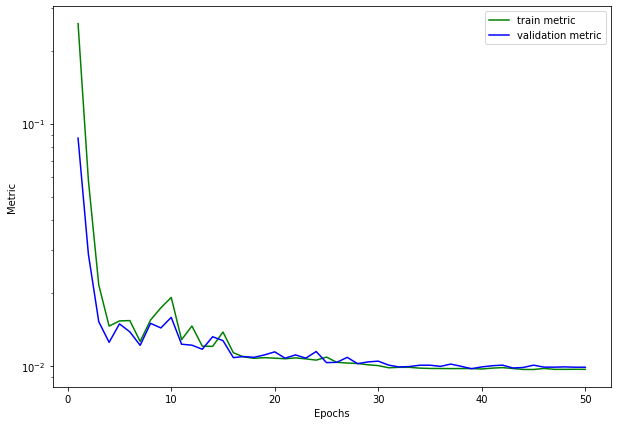

In [33]:
# plot metric (MAE) history

plt.figure(figsize=(10, 7))
plt.plot(range(1,len(hist_metric)+1), hist_metric,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.yscale("log")

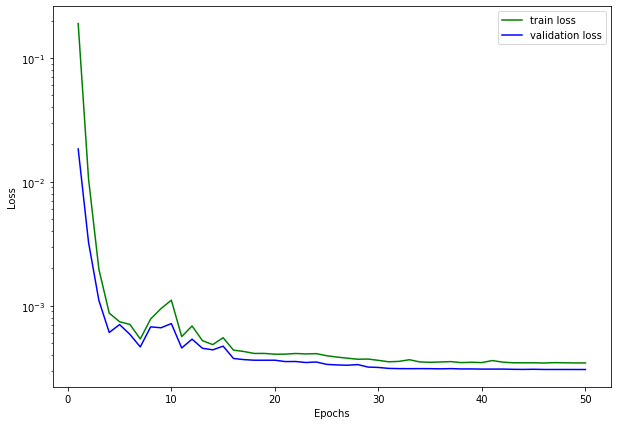

In [34]:
# plot loss (MSE) history

plt.figure(figsize=(10, 7))
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1),hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.yscale("log")

In [29]:
#test

# load the best model checkpoint
best_model = torch.load('best_model.pth')
best_model_epoch = best_model['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")


model = DnCNN()
model.load_state_dict(best_model['model_state_dict'])

#let's do this on cpu (inference is fast)
model.to(torch.device('cpu'))

# test 10 cases
X_test_pt = X_test_pt[:10].type(torch.float).to(torch.device('cpu'))
prediction = model(X_test_pt)

Best model was saved at 50 epochs



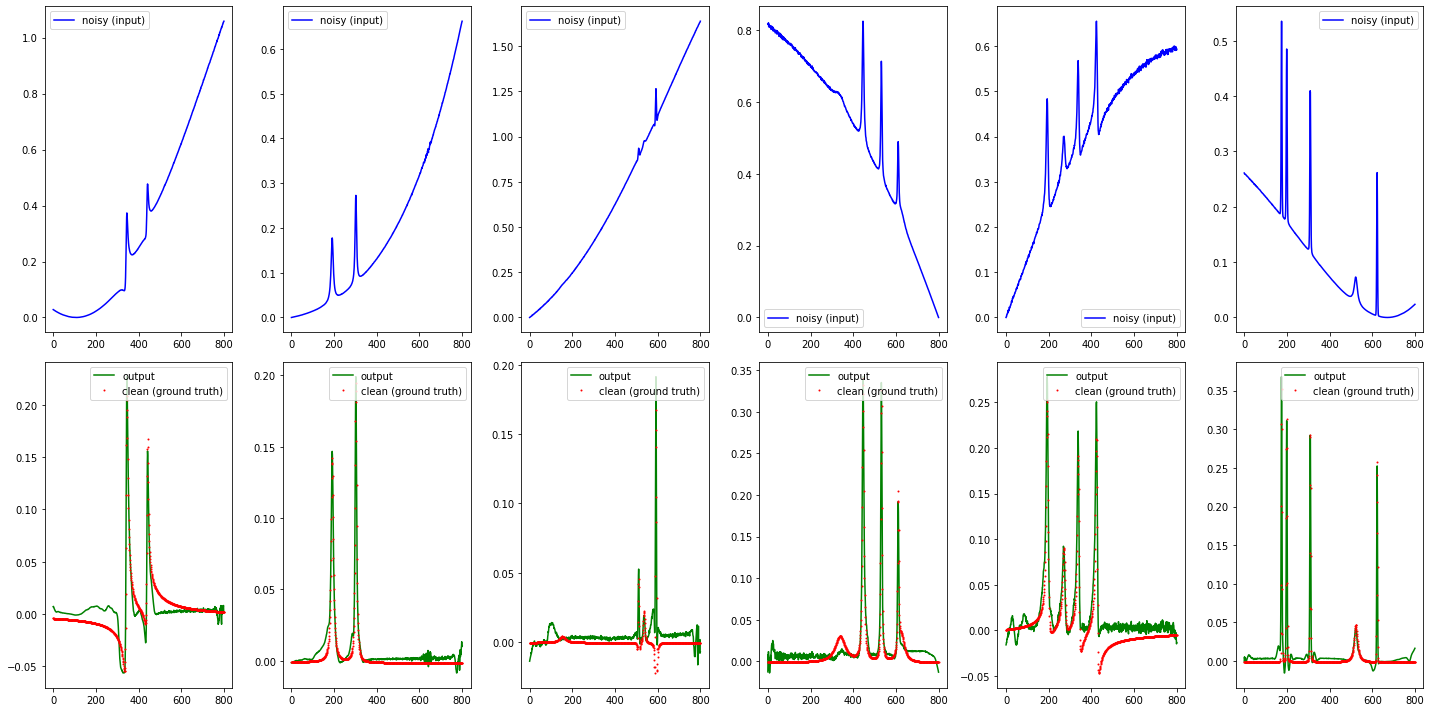

In [32]:
#plot results
shift=0
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(2,6,i+1)
    plt.plot(X_test_pt[i+shift].permute(1,0).numpy().reshape(801,), '-b',label="noisy (input)") #input noisy spectrum
    plt.legend()
    plt.subplot(2,6,i+7)
    plt.plot(prediction[i+shift].permute(1,0).detach().numpy().reshape(801,), '-g',label="output") #cleaned spectrum predicted by te model
    plt.plot(Y_test_pt[i+shift].permute(1,0).numpy().reshape(801,), 'or', markersize=1, label = "clean (ground truth)") #ground truth
    plt.legend()
plt.tight_layout()    

**spunti per sperimentare**

*   test model variations: with and w/o BN, try theusing dilated convolutions ([dilation](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) parameter), try to analyise in parallel the input with different kernels:


```
# code snippet example
self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=20, padding='same', bias=False)
    self.relu1 = nn.ReLU()

hlayers = []
for _ in range(num_layers):
  hlayers.append(nn.Conv1d(in_channels=64, out_channels=64, kernel_size=20, padding='same', bias=False))
  hlayers.append(nn.ReLU())

self.central_block = nn.Sequential(*hlayers) 

self.conv1_b = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, padding='same', bias=False)
    self.relu1_b = nn.ReLU()

hlayers_b = []
for _ in range(num_layers):
  hlayers_b.append(nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5, padding='same', bias=False))
  hlayers_b.append(nn.ReLU())

self.central_block_b = nn.Sequential(*hlayers_b)

self.conv3 = nn.Conv1d(in_channels=64*2, out_channels=1, kernel_size=1, padding='same', bias=False)

def forward(self, x):
    out = self.relu1(self.conv1(x))
    out = self.central_block(out)

    out_b = self.relu1_b(self.conv1_b(x))
    out_b = self.central_block_b(out_b)
                             
    out = torch.cat((out,out_b), dim=1)
    out = self.conv3(out)

    # residual learning (this way out become the clean spectrum and the network has only to learn the "noise")
    out = x - out
    return out
```



*   test medium and high noise cases ...

